# Starbucks

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import kstest
import numpy as np
from scipy.stats import zscore
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
# Configuración de seaborn
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

## Carga y preparación de Datos
### 1. Carga de los archivos de Starbucks

In [2]:
filename = "../data/Starbucks/portfolio.json"
portfolio_df = pd.read_json(filename, lines=True, orient="records")

portfolio_df.head(3)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [3]:
filename = "../data/Starbucks/profile.json"
profile_df = pd.read_json(filename, lines=True, orient="records")

profile_df.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [4]:
filename = "../data/Starbucks/transcript.json"
transcript_df = pd.read_json(filename, lines=True, orient="records")

transcript_df.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


### 2. Análisis de Edad

<Axes: xlabel='age', ylabel='Count'>

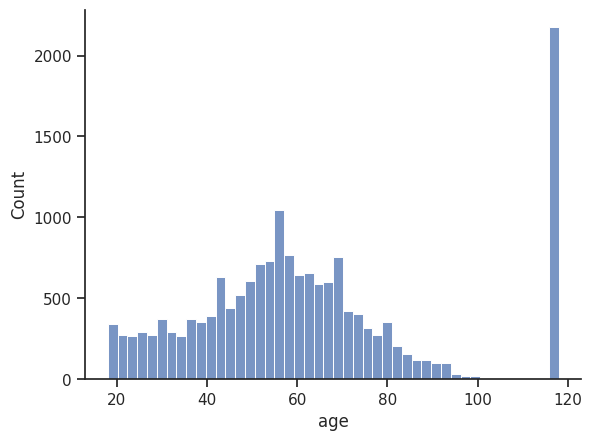

In [5]:
sns.histplot(data=profile_df, x="age")

In [6]:
profile_df["age"].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [7]:
# Prueba de normalidad

stat, p = kstest(profile_df["age"], 'norm')

print('Estadística de prueba:', stat)
print('Valor p:', p)

# Interpretar el resultado
alpha = 0.05
if p > alpha:
    print('Los datos parecen ser normales (no se puede rechazar la hipótesis nula)')
else:
    print('Los datos no parecen ser normales (se rechaza la hipótesis nula)')

Estadística de prueba: 1.0
Valor p: 0.0
Los datos no parecen ser normales (se rechaza la hipótesis nula)


### 3. Conversión de fecha

In [8]:
profile_df["became_member_on_converted"] = pd.to_datetime(profile_df["became_member_on"], format='%Y%m%d')
profile_df.head(3)

,gender,age,id,became_member_on,income,became_member_on_converted
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12


### 4. Tratamiento de valores nulos

In [9]:
gender_mode = profile_df["gender"].mode()[0]

profile_df.loc[profile_df["gender"].isnull(), "gender"] = "Missing"
profile_df["gender_filled"] = profile_df["gender"]
profile_df.loc[profile_df["gender"] == "Missing", "gender_filled"] = gender_mode

profile_df.head(3)

,gender,age,id,became_member_on,income,became_member_on_converted,gender_filled
0,Missing,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,M
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,F
2,Missing,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,M


### 5. Filtrado de Edades

In [10]:
print("Tamaño inicial: ", len(profile_df))
profile_df = profile_df[profile_df["age"] <= 100]
print("Tamaño después del filtrado: ", len(profile_df))

Tamaño inicial:  17000
Tamaño después del filtrado:  14820


### 6. Subconjunto de Transacciones

In [11]:
print("Tamaño inicial: ", len(transcript_df))
transactions_df = transcript_df[transcript_df["event"] == "transaction"]
print("Tamaño después del filtrado: ", len(transactions_df))

Tamaño inicial:  306534
Tamaño después del filtrado:  138953


In [12]:
transactions_df["amount"] = transactions_df['value'].apply(lambda row: row['amount'])
transactions_df.head(3)

/tmp/ipykernel_2714/3602024779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_df["amount"] = transactions_df['value'].apply(lambda row: row['amount'])


,person,event,value,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23


## Agrupación y análisis de Transacciones
### 1. Agrupación por personas

In [13]:
transactions_amount_grouped_df = (
    transactions_df
        .groupby("person")["amount"]
        .agg(['min', 'max', 'mean'])
        .reset_index()
        .rename(columns={
            "min": "min_amount",
            "max": "max_amount",
            "mean": "mean_amount"
            })
)

transactions_amount_grouped_df.head(3)

,person,min_amount,max_amount,mean_amount
0,0009655768c64bdeb2e877511632db8f,8.57,28.16,15.950000
1,00116118485d4dfda04fdbaba9a87b5c,0.20,3.19,1.363333
2,0011e0d4e6b944f998e987f904e8c1e5,8.96,23.03,15.892000


In [14]:
# Time
transactions_time_grouped_df = (
    transactions_df
        .groupby("person")["time"]
        .agg(['count', 'sum', 'mean'])
        .reset_index()
        .rename(columns={
            "count": "count_time",
            "sum": "sum_time",
            "mean": "mean_time"
            })
)
transactions_time_grouped_df.head(3)

,person,count_time,sum_time,mean_time
0,0009655768c64bdeb2e877511632db8f,8,4344,543.0
1,00116118485d4dfda04fdbaba9a87b5c,3,1224,408.0
2,0011e0d4e6b944f998e987f904e8c1e5,5,2256,451.2


In [15]:
transactions_grouped_df = pd.merge(
    transactions_amount_grouped_df,
    transactions_time_grouped_df,
    on="person",
    how="inner",
)

transactions_grouped_df.head(3)

,person,min_amount,max_amount,mean_amount,count_time,sum_time,mean_time
0,0009655768c64bdeb2e877511632db8f,8.57,28.16,15.950000,8,4344,543.0
1,00116118485d4dfda04fdbaba9a87b5c,0.20,3.19,1.363333,3,1224,408.0
2,0011e0d4e6b944f998e987f904e8c1e5,8.96,23.03,15.892000,5,2256,451.2


### 2. Cruce de Dataframes

In [16]:
profile_df.head(3)

,gender,age,id,became_member_on,income,became_member_on_converted,gender_filled
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,F
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,F
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018-04-26,M


In [17]:
merged_df = (
    pd.merge(
        profile_df[["id", "age", "income", "gender_filled"]],
        transactions_grouped_df,
        left_on="id",
        right_on="person",
        how="inner"
        )
        .drop(columns="id")
        .set_index("person")
)

merged_df.head(3)

,age,income,gender_filled,min_amount,max_amount,mean_amount,count_time,sum_time,mean_time
person,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,F,21.51,32.28,25.670000,3,690,230.000000
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,F,17.78,29.72,22.752857,7,2160,308.571429
e2127556f4f64592b11af22de27a7932,68,70000.0,M,17.88,21.43,19.243333,3,1104,368.000000


## Tratamiento de Outliers
### 1. Detección

In [18]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return lower_bound, upper_bound


def detect_outliers_zscore(data, column, threshold=3):
    z_scores = zscore(data[column])
    
    lower_bound = np.min(data[column][z_scores < threshold])
    upper_bound = np.max(data[column][z_scores > threshold])
    
    return lower_bound, upper_bound


def detect_outliers_percentile(data, column, threshold=0.25):
    lower_bound = data[column].quantile(threshold)
    upper_bound = data[column].quantile(1 - threshold)
    
    return lower_bound, upper_bound


def transform_outliers(data, column, lower_bound, upper_bound):
    data.loc[data[column] < lower_bound, column] = lower_bound
    data.loc[data[column] > upper_bound, column] = upper_bound
    return data

In [19]:
lower_bound, upper_bound = detect_outliers_iqr(merged_df, "age")
print(f"Límite inferior: {lower_bound}")
print(f"Límite superior: {upper_bound}")

Límite inferior: 6.0
Límite superior: 102.0


In [20]:
lower_bound, upper_bound = detect_outliers_zscore(merged_df, "age", threshold=2.5)
print(f"Límite inferior: {lower_bound}")
print(f"Límite superior: {upper_bound}")

Límite inferior: 18
Límite superior: 100


In [21]:
lower_bound, upper_bound = detect_outliers_percentile(merged_df, "age", threshold=0.15)
print(f"Límite inferior: {lower_bound}")
print(f"Límite superior: {upper_bound}")

Límite inferior: 34.0
Límite superior: 72.0


In [22]:
merged_df = transform_outliers(merged_df, "age", lower_bound, upper_bound)
merged_df.head(3)

,age,income,gender_filled,min_amount,max_amount,mean_amount,count_time,sum_time,mean_time
person,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,F,21.51,32.28,25.670000,3,690,230.000000
78afa995795e4d85b5d9ceeca43f5fef,72,100000.0,F,17.78,29.72,22.752857,7,2160,308.571429
e2127556f4f64592b11af22de27a7932,68,70000.0,M,17.88,21.43,19.243333,3,1104,368.000000


## Dashboard

In [23]:

app = dash.Dash(__name__)

df = merged_df

# Definir el diseño del dashboard
app.layout = html.Div([
    html.H1("Dashboard"),
    dcc.Dropdown(
        id='dropdown-column',
        options=[{'label': col, 'value': col} for col in df.columns],
        value='age'  # Valor por defecto
    ),
    html.Div(id='output-chart')
])

# Definir la lógica de la aplicación Dash
@app.callback(
    Output('output-chart', 'children'),
    [Input('dropdown-column', 'value')]
)
def update_chart(selected_column):
    if selected_column in ['age', 'count_time']:
        # Conteo agrupado
        grouped_count = df.groupby(selected_column).size().reset_index(name='Count')
        fig = px.bar(grouped_count, x=selected_column, y='Count', title=f'Conteo Agrupado por {selected_column}')
    elif selected_column in ['income', 'min_amount', 'max_amount', 'mean_amount', 'sum_time', 'mean_time']:
        # Histograma
        fig = px.histogram(df, x=selected_column, title=f'Histograma de {selected_column}')
    else:
        return html.Div("Seleccione una columna válida para mostrar el gráfico")
    
    return dcc.Graph(figure=fig)

In [24]:
app.run_server(mode="inline", host="0.0.0.0", port=8888, use_reloader=True)

### Ejemplos del dashboard

![age](../resouces/2-Starbucks/age.png)

![income](../resouces/2-Starbucks/income.png)

![mean-amount](../resouces/2-Starbucks/mean-amount.png)

## Storytelling

**Perfilando a nuestros clientes**

Como parte del equipo de marketing de Starbucks, les hablaré sobre cómo hemos perfilado a nuestros clientes para mejorar su experiencia.

1. **Edad:**
   - La mayoría de nuestros clientes tienen entre 42 y 66 años.
   - Edad promedio: alrededor de 55 años.
   - Esto nos ayuda a visualizar a nuestro cliente típico y adaptar nuestras estrategias en consecuencia.

2. **Ingresos:**
   - Ingreso promedio: $63,000.
   - La mayoría gana entre $49,000 y $79,000 al año.
   - Esto nos da una idea de su capacidad de gasto y cómo podemos ajustar nuestras ofertas y segmentación de mercado.

3. **Género:**
   - Mayoría masculina (8,295).
   - Considerable cantidad de clientes femeninas (5,988) y un grupo "otros" (204).
   - Esto nos permite adaptar nuestras campañas publicitarias para incluir mensajes que resuenen con diferentes identidades de género.

4. **Comportamiento de compra:**
   - Monto promedio: $15.25.
   - Gran variabilidad, con algunos clientes realizando compras significativamente más grandes.
   - Esto nos da una comprensión más profunda de los hábitos de gasto y nos ayuda a ajustar nuestras estrategias de precios y promociones.

Entendemos mejor quiénes son nuestros clientes y qué los impulsa. Estamos seguros de que podemos ofrecer experiencias aún más satisfactorias y fortalecer la lealtad de la marca en el proceso.

Sin embargo, alcanzar un monto promedio de transacción de $21, que corresponde al percentil 75%, puede resultar desafiante. Actualmente, nuestro monto promedio (percentil 50%) es de $15.25. Esto requiere una estrategia cuidadosamente diseñada para aumentar el valor de compra por cliente, lo que podría implicar ajustes en nuestros productos, precios o promociones.
